# We're going to put a prior on height

**Verdict**:

**Height Prior:** Looking good. Doesn't quite recover all the little differences in height, but its good enough.

**Divergences:** Divergences ever present due to the centered parameterisation of the mode frequencies. There appears to be some biased convergence of certain parameters (particularly the $\sigma$s, as expected), but for the physical hierarchical parameters these biases are no different than those present when fitting to the amplitudes directly with no divergences present.

**To-do:** Run in a fully non-centered parameterisation and assess the biases on the final results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [2]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.sqr(tt.cos(i)))
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sqr(tt.sin(i)))
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * tt.sqr((3. * tt.sqr(tt.cos(i)) - 1.)))
        eps2 = tt.set_subtensor(eps2[1], (3./8.) * tt.sqr(tt.sin(2*i)))
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        return eps
            
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/tt.sqr(w)*tt.sqr((self.f - freq)))
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    # Small separations are fractional
    def asymptotic(self, n, numax, deltanu, alpha, epsilon, d=0.): 
        nmax = (numax / deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * deltanu

    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, deltanu, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon, -d02)

    def gaussian(self, freq, numax, w, A):
        return A * tt.exp(-0.5 * tt.sqr((freq - numax)) / tt.sqr(w))

    def A0(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)
        if theano:
            return height
        else:
            return height.eval()
    
    def A1(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V1        
        if theano:
            return height
        else:
            return height.eval()
    
    def A2(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V2      
        if theano:
            return height
        else:
            return height.eval()

Build the range

In [3]:
nmodes = 4
nbase = 16
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .1
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

Build the frequencies

In [4]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

In [5]:
mod = model(ff, n0_, n1_, n2_)

In [6]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]

f0_true = mod.f0(init_f)
f1_true = mod.f1(init_f)
f2_true = mod.f2(init_f)

sigma0_ = 1.5
sigma1_ = 2.0
sigma2_ = .5
f0_ = mod.f0(init_f) + np.random.randn(len(f0_true)) * sigma0_
f1_ = mod.f1(init_f) + np.random.randn(len(f1_true)) * sigma1_
f2_ = mod.f2(init_f) + np.random.randn(len(f2_true)) * sigma2_

In [7]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

Reset model for new frequency range

In [8]:
mod = model(f, n0_, n1_, n2_)

Build the mode amplitudes

In [9]:
w_ = (0.25 * numax_)/2.355
V1_ = 1.2
V2_ = 0.7
A_ = 10.
init_h =[numax_,   #numax
         w_,       #envelope width
         A_,       #envelope amplitude
         V1_,      #dipole visibility
         V2_       #ocotopole visibility
        ]
sigmaA_ = .2
amps = [mod.A0(f0_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A1(f1_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A2(f2_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_]

widths = [np.ones(len(f0_)) * 2.0,
          np.ones(len(f0_)) * 2.0,
          np.ones(len(f0_)) * 2.0,]

In [10]:
split_ = 1.
incl_ = np.pi/4.
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       widths[0],             # l0 widths
       widths[1],             # l1 widths
       widths[2],             # l2 widths
       amps[0]**2 * 2.0 / np.pi / widths[0] ,# l0 heights
       amps[1]**2 * 2.0 / np.pi / widths[1] ,# l1 heights
       amps[2]**2 * 2.0 / np.pi / widths[2] ,# l2 heights
       split_,       # splitting
       incl_,                    # inclination angle
       1.                           # background parameters
        ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

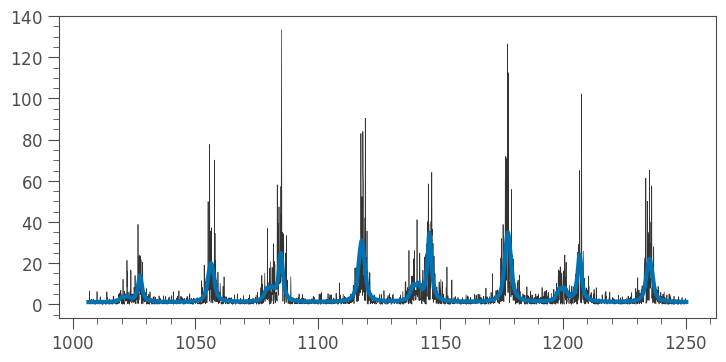

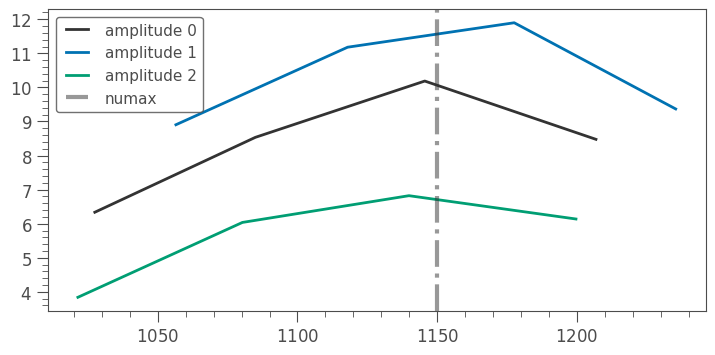

In [11]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(f0_, amps[0], label='amplitude 0', lw=2)
    ax.plot(f1_, amps[1], label='amplitude 1', lw=2)
    ax.plot(f2_, amps[2], label='amplitude 2', lw=2)
    ax.axvline(numax_, lw=3, ls='-.', label='numax', alpha=.5)
    ax.legend()
    plt.show()    

## First lets fit the mode heights...

In [44]:
pm_model = pm.Model()

with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    w = pm.Normal('w', w_, 1., testval=w_)
    A = pm.Normal('A', A_, 10., testval=A_)
    V1 = pm.Normal('V1', V1_, 0.1, testval=V1_)
    V2 = pm.Normal('V2', V2_, 0.1, testval=V2_)
    
    sigmaA = pm.HalfNormal('sigmaA', 1., testval=0.2)
    Da0 = pm.Normal('Da0',0, 1, shape=len(f0_))
    Da1 = pm.Normal('Da1',0, 1, shape=len(f0_))
    Da2 = pm.Normal('Da2',0, 1, shape=len(f0_))
                    
    a0 = pm.Deterministic('a0', sigmaA * Da0 + mod.A0(f0_, [numax, w, A, V1, V2])) 
    a1 = pm.Deterministic('a1', sigmaA * Da1 + mod.A1(f1_, [numax, w, A, V1, V2])) 
    a2 = pm.Deterministic('a2', sigmaA * Da2 + mod.A2(f2_, [numax, w, A, V1, V2])) 
    
    pm.Normal('like0', a0, .1, observed=amps[0])
    pm.Normal('like1', a1, .1, observed=amps[1])
    pm.Normal('like2', a2, .1, observed=amps[2])    
    
    trace = pm.sample(tune=1000,chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [Da2, Da1, Da0, sigmaA, V2, V1, A, w, numax]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:16<00:00, 369.85draws/s]


In [45]:
pm.summary(trace)

mean        sd  mc_error      hpd_2.5     hpd_97.5  \
numax   1149.801024  0.941099  0.020497  1148.019217  1151.699217   
w        122.176397  0.933136  0.019402   120.455261   124.095784   
A          9.916314  0.187892  0.006525     9.529786    10.284475   
V1         1.200937  0.027758  0.000895     1.151147     1.257651   
V2         0.689228  0.021720  0.000699     0.645014     0.730470   
Da0__0     1.033776  0.549555  0.015804    -0.048387     2.123968   
Da0__1    -0.271736  0.621247  0.020222    -1.445133     1.037363   
Da0__2     0.862276  0.670797  0.021700    -0.455091     2.197175   
Da0__3    -1.326340  0.683153  0.021488    -2.700346    -0.082783   
Da1__0     0.022611  0.566784  0.012648    -1.042676     1.172994   
Da1__1    -1.034447  0.676131  0.016822    -2.436159     0.205424   
Da1__2     0.939992  0.676589  0.017546    -0.398770     2.188166   
Da1__3     0.157246  0.575573  0.013566    -1.035940     1.246454   
Da2__0    -0.307538  0.472868  0.011797    -1.283528     0.567666   
Da2__1     0.702048  0.580215  0.015722    -0.417192     1.838407   
Da2__2     0.038310  0.631374  0.016778    -1.107238     1.339244   
Da2__3    -0.490083  0.613599  0.016873    -1.744511     0.645234   
sigmaA     0.294512  0.092211  0.003295     0.143829     0.480155   
a0__0      6.295901  0.096085  0.001749     6.113867     6.487442   
a0__1      8.541974  0.096462  0.002164     8.341790     8.719112   
a0__2     10.151105  0.096230  0.002295     9.960347    10.334145   
a0__3      8.530311  0.096998  0.002195     8.339766     8.718260   
a1__0      8.900679  0.092216  0.001731     8.723253     9.080963   
a1__1     11.221880  0.099114  0.002253    11.023129    11.405690   
a1__2     11.859288  0.095945  0.001733    11.660207    12.040943   
a1__3      9.359923  0.096769  0.001946     9.170763     9.537153   
a2__0      3.851295  0.094922  0.001700     3.676737     4.043456   
a2__1      6.006560  0.093841  0.001932     5.810418     6.184617   
a2__2      6.821662  0.095776  0.001906     6.643883     7.009024   
a2__3      6.152646  0.092587  0.001744     5.963140     6.323224   

              n_eff      Rhat  
numax   1746.975361  0.999286  
w       2284.832331  1.000080  
A        907.563830  1.001076  
V1       984.091710  1.000803  
V2       934.057115  1.001358  
Da0__0  1221.678855  1.000497  
Da0__1  1030.908837  1.001908  
Da0__2  1013.697097  1.002227  
Da0__3  1012.453572  1.000005  
Da1__0  1693.269710  1.001492  
Da1__1  1544.214082  0.999678  
Da1__2  1425.437635  0.999503  
Da1__3  1596.067878  0.999341  
Da2__0  1384.225961  0.999325  
Da2__1  1094.818778  1.000494  
Da2__2  1280.611942  0.999307  
Da2__3  1179.313980  0.999386  
sigmaA   673.777293  1.000528  
a0__0   2703.273048  0.999070  
a0__1   2274.331080  0.999680  
a0__2   2002.578351  1.002521  
a0__3   2036.002271  0.999922  
a1__0   2564.692044  0.999924  
a1__1   2383.388586  0.999953  
a1__2   2388.639811  0.999358  
a1__3   2753.972127  0.999071  
a2__0   2471.120201  0.999343  
a2__1   2372.713181  1.000077  
a2__2   2348.991494  0.999239  
a2__3   2401.617042  0.999056

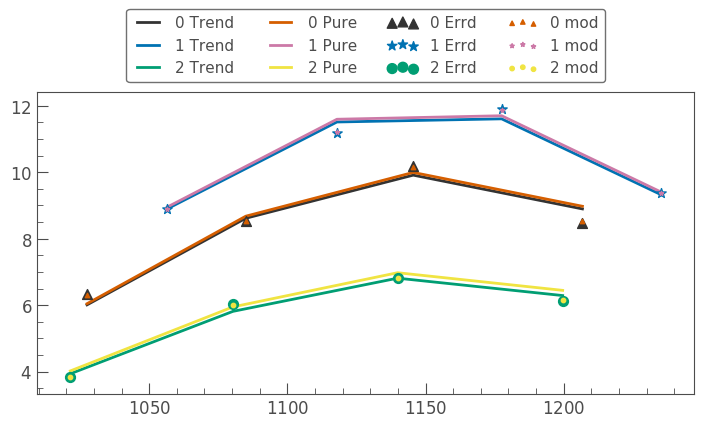

In [46]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'w', 'A', 'V1','V2']]
    resls = [np.median(trace[label],axis=0) for label in ['a0','a1','a2']]
       
    ax.plot(f0_, mod.A0(f0_, res,theano=False), label='0 Trend',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, res,theano=False), label='1 Trend',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, res,theano=False), label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_, amps[0], marker='^',label='0 Errd',  s=50, zorder=2)
    ax.scatter(f1_, amps[1], marker='*',label='1 Errd',  s=50, zorder=2)
    ax.scatter(f2_, amps[2], marker='o',label='2 Errd',  s=50, zorder=2)   
  
    ax.plot(f0_, mod.A0(f0_, init_h, theano=False), label='0 Pure',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, init_h, theano=False), label='1 Pure',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, init_h, theano=False), label='2 Pure',lw=2, zorder=1)

    ax.scatter(f0_, resls[0], marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(f1_, resls[1], marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(f2_, resls[2], marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    

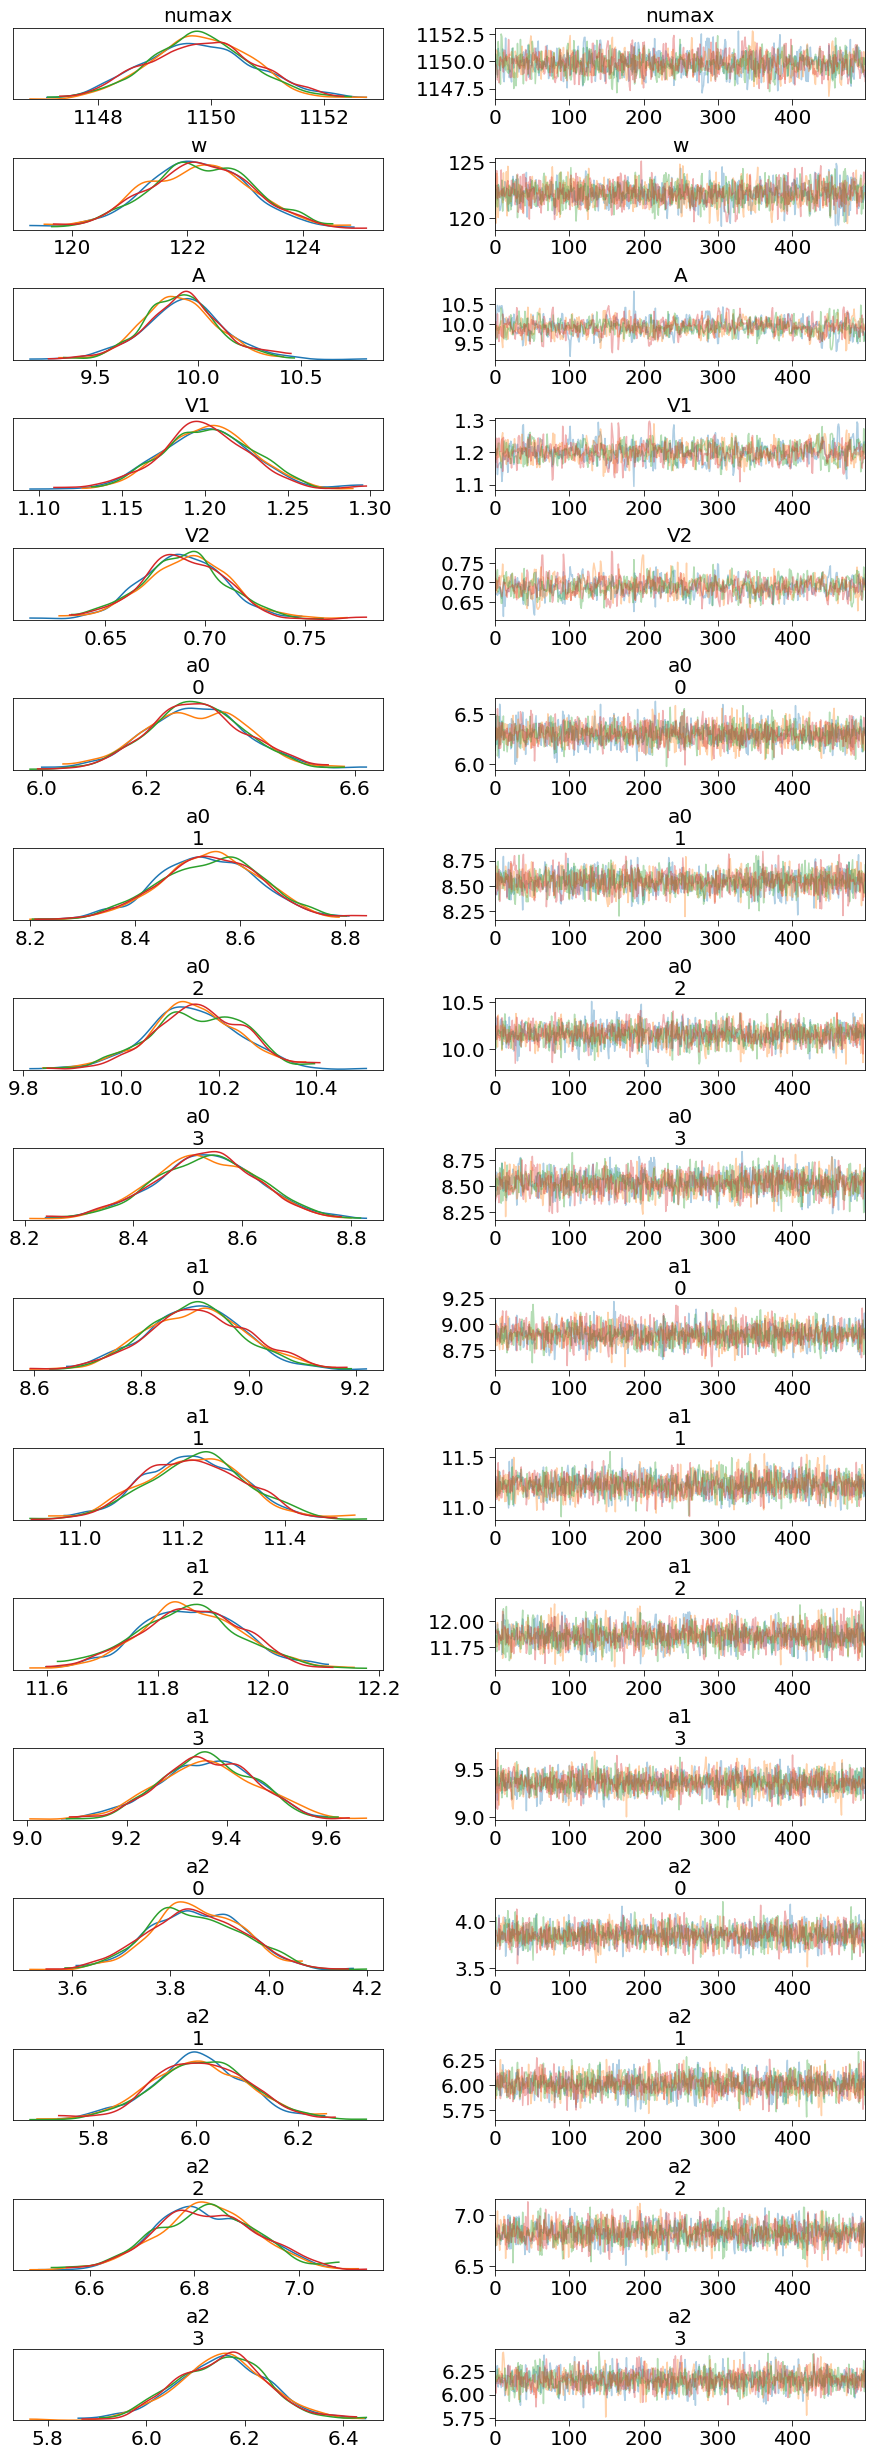

In [47]:
pm.traceplot(trace, var_names=['numax', 'w', 'A', 'V1','V2', 'a0','a1','a2']);

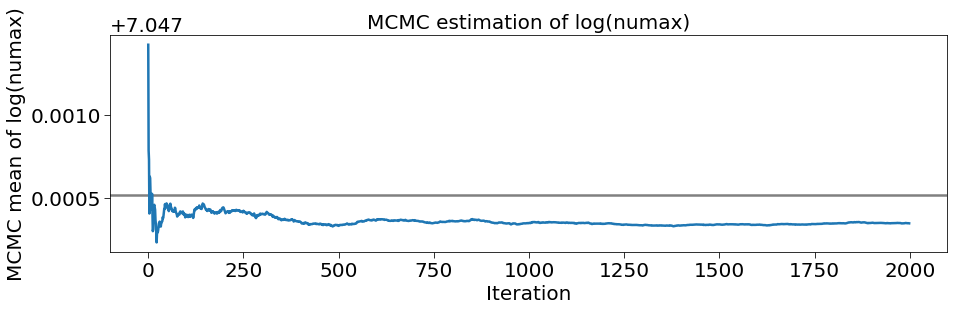

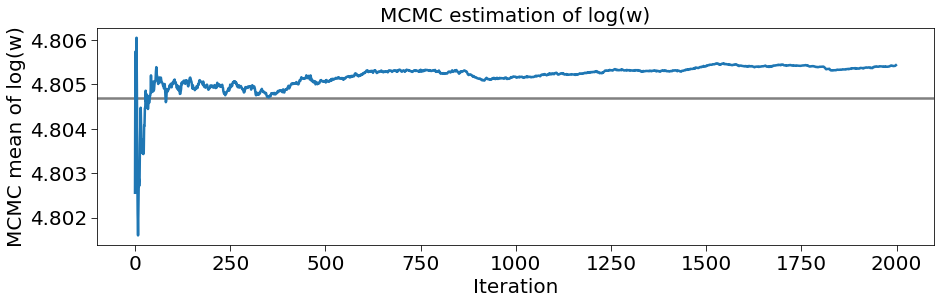

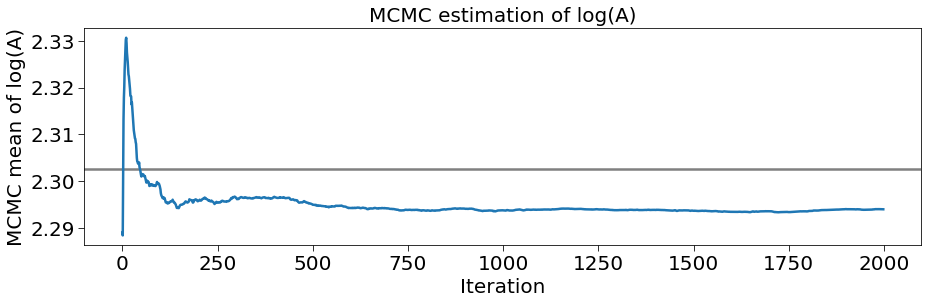

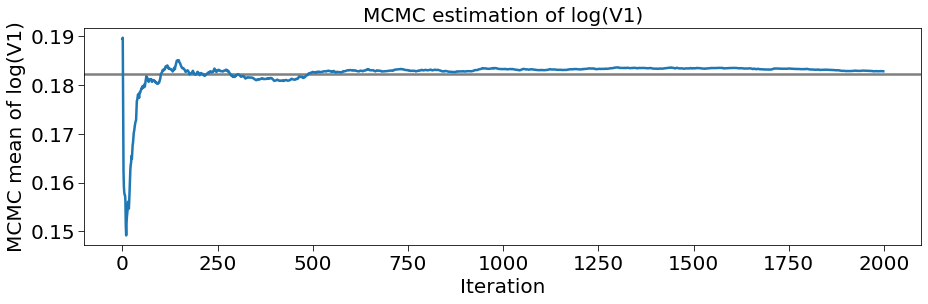

In [49]:
biasplot('numax',numax_)
biasplot('w',w_)
biasplot('A',A_)
biasplot('V1',V1_)

# Now lets try and fit this

In [17]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    deltanu = pm.Normal('deltanu', deltanu_, 1., testval=deltanu_)
    alpha = pm.Normal('alpha', alpha_, 0.001, testval=alpha_)
    epsilon = pm.Normal('epsilon', epsilon_, 1., testval=epsilon_)
    d01     = pm.Normal('d01', d01_, 0.01, testval=d01_)   
    d02     = pm.Normal('d02', d02_, 0.01, testval=d02_)
    
    sigma0 = pm.HalfNormal('sigma0', 1., testval=1.5)
    sigma1 = pm.HalfNormal('sigma1', 1., testval=2.)
    sigma2 = pm.HalfNormal('sigma2', 1., testval=.5)
    
    f0 = pm.Normal('f0', mod.f0([numax, deltanu, alpha, epsilon, d01, d02]), sigma0, shape=len(f0_))
    f1 = pm.Normal('f1', mod.f1([numax, deltanu, alpha, epsilon, d01, d02]), sigma1, shape=len(f1_))
    f2 = pm.Normal('f2', mod.f2([numax, deltanu, alpha, epsilon, d01, d02]), sigma2, shape=len(f2_))

    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))

    w = pm.Normal('w', w_, 1., testval=w_)
    A = pm.Normal('A', A_, 1., testval=A_)
    V1 = pm.Normal('V1', V1_, 0.1, testval=V1_)
    V2 = pm.Normal('V2', V2_, 0.1, testval=V2_)
    
    sigmaA = pm.HalfNormal('sigmaA', 1., testval=0.2)
    Da0 = pm.Normal('Da0',0, 1, shape=len(f0_))
    Da1 = pm.Normal('Da1',0, 1, shape=len(f0_))
    Da2 = pm.Normal('Da2',0, 1, shape=len(f0_))
                    
    a0 = pm.Deterministic('a0', sigmaA * Da0 + mod.A0(f0_, [numax, w, A, V1, V2])) 
    a1 = pm.Deterministic('a1', sigmaA * Da1 + mod.A1(f1_, [numax, w, A, V1, V2])) 
    a2 = pm.Deterministic('a2', sigmaA * Da2 + mod.A2(f2_, [numax, w, A, V1, V2]))   
    
    h0 = pm.Deterministic('h0', 2*tt.sqr(a0)/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*tt.sqr(a1)/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*tt.sqr(a2)/np.pi/g2)
    
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = BNormal('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [18]:
with pm_model:
    trace = pm.sample(tune=1000, chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, cosi, xsplit, Da2, Da1, Da0, sigmaA, V2, V1, A, w, g2, g1, g0, f2, f1, f0, sigma2, sigma1, sigma0, d02, d01, epsilon, alpha, deltanu, numax]
Sampling 4 chains: 100%|██████████| 6000/6000 [19:08<00:00,  2.92draws/s] 
ERROR:pymc3:There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
pm.summary(trace)

mean         sd  mc_error      hpd_2.5     hpd_97.5  \
numax    1149.865649   0.982458  0.032117  1147.879621  1151.681684   
deltanu    59.916088   0.272124  0.010886    59.375537    60.453047   
alpha       0.010062   0.001003  0.000027     0.008033     0.011931   
epsilon     1.125690   0.085876  0.003444     0.957971     1.295526   
d01         0.503037   0.008219  0.000182     0.485767     0.517878   
d02         0.101528   0.007540  0.000192     0.086880     0.116567   
f0__0    1027.299263   0.240504  0.008133  1026.822469  1027.761120   
f0__1    1085.148515   0.154751  0.003566  1084.816532  1085.422767   
f0__2    1145.808320   0.200163  0.007378  1145.425155  1146.230538   
f0__3    1207.272934   0.186259  0.004575  1206.889570  1207.616770   
f1__0    1056.626690   0.185452  0.004987  1056.276490  1057.018791   
f1__1    1118.104563   0.181408  0.004988  1117.751363  1118.461716   
f1__2    1177.404983   0.190648  0.005093  1177.045019  1177.757419   
f1__3    1234.993864   0.201466  0.005268  1234.571093  1235.365755   
f2__0    1021.641178   0.557545  0.029193  1020.629290  1022.493846   
f2__1    1080.299574   0.379849  0.011493  1079.532620  1081.026416   
f2__2    1139.535856   0.431940  0.018621  1138.884781  1140.509263   
f2__3    1199.800034   0.349470  0.009992  1199.136282  1200.446834   
w         122.168165   0.985920  0.031549   120.348726   124.093850   
A          10.268093   0.368133  0.011413     9.591389    11.041683   
V1          1.189686   0.052699  0.001495     1.090919     1.297098   
V2          0.672218   0.048841  0.001823     0.571445     0.758296   
Da0__0      0.108830   0.869449  0.028367    -1.618390     1.707716   
Da0__1      0.524429   0.964630  0.032431    -1.428546     2.247900   
Da0__2      0.140214   0.908081  0.022418    -1.800428     1.778164   
Da0__3     -0.357630   0.928187  0.021458    -2.133668     1.412685   
Da1__0      0.326093   0.919182  0.025643    -1.497119     2.051161   
Da1__1     -0.345683   0.976303  0.021758    -2.406926     1.449153   
Da1__2     -0.048896   0.911142  0.024164    -1.745778     1.796224   
Da1__3      0.188344   0.885160  0.023174    -1.822038     1.711507   
...              ...        ...       ...          ...          ...   
sigmaA      0.283772   0.229950  0.008147     0.000155     0.730842   
a0__0       6.246571   0.310993  0.008025     5.644350     6.858116   
a0__1       9.116955   0.420176  0.012992     8.299710     9.966816   
a0__2      10.320325   0.413497  0.011508     9.550956    11.108541   
a0__3       9.074660   0.432555  0.011565     8.216061     9.914248   
a1__0       9.233663   0.379606  0.012252     8.538298    10.001676   
a1__1      11.667070   0.488032  0.013534    10.642587    12.593641   
a1__2      11.873792   0.427788  0.011522    11.098800    12.753008   
a1__3       9.628098   0.373019  0.010212     8.907230    10.383007   
a2__0       3.967155   0.314035  0.009841     3.322988     4.555852   
a2__1       5.929484   0.394561  0.012202     5.179894     6.700425   
a2__2       6.816531   0.437101  0.015029     5.944252     7.634848   
a2__3       6.324636   0.393651  0.012757     5.545232     7.076375   
h0__0      11.968060   3.414189  0.096468     6.833046    19.022630   
h0__1      33.353742   7.298260  0.172737    21.245425    48.671505   
h0__2      31.214408   6.625968  0.180069    19.527889    43.798316   
h0__3      33.713500  10.728537  0.311870    14.865383    54.401712   
h1__0      29.515354   6.593465  0.168324    18.518478    42.800388   
h1__1      63.227606  15.691683  0.587367    35.130499    92.105392   
h1__2      45.836090   9.403036  0.260339    27.744412    64.337996   
h1__3      29.336491   6.274534  0.176161    18.517020    41.306614   
h2__0       9.605025   8.040263  0.323430     2.200282    24.027768   
h2__1      13.823383   5.063879  0.115940     5.806968    24.053986   
h2__2      17.282593   9.545449  0.320432     6.546073    35.043323   
h2__3      11.564590   4.741590  0.14737

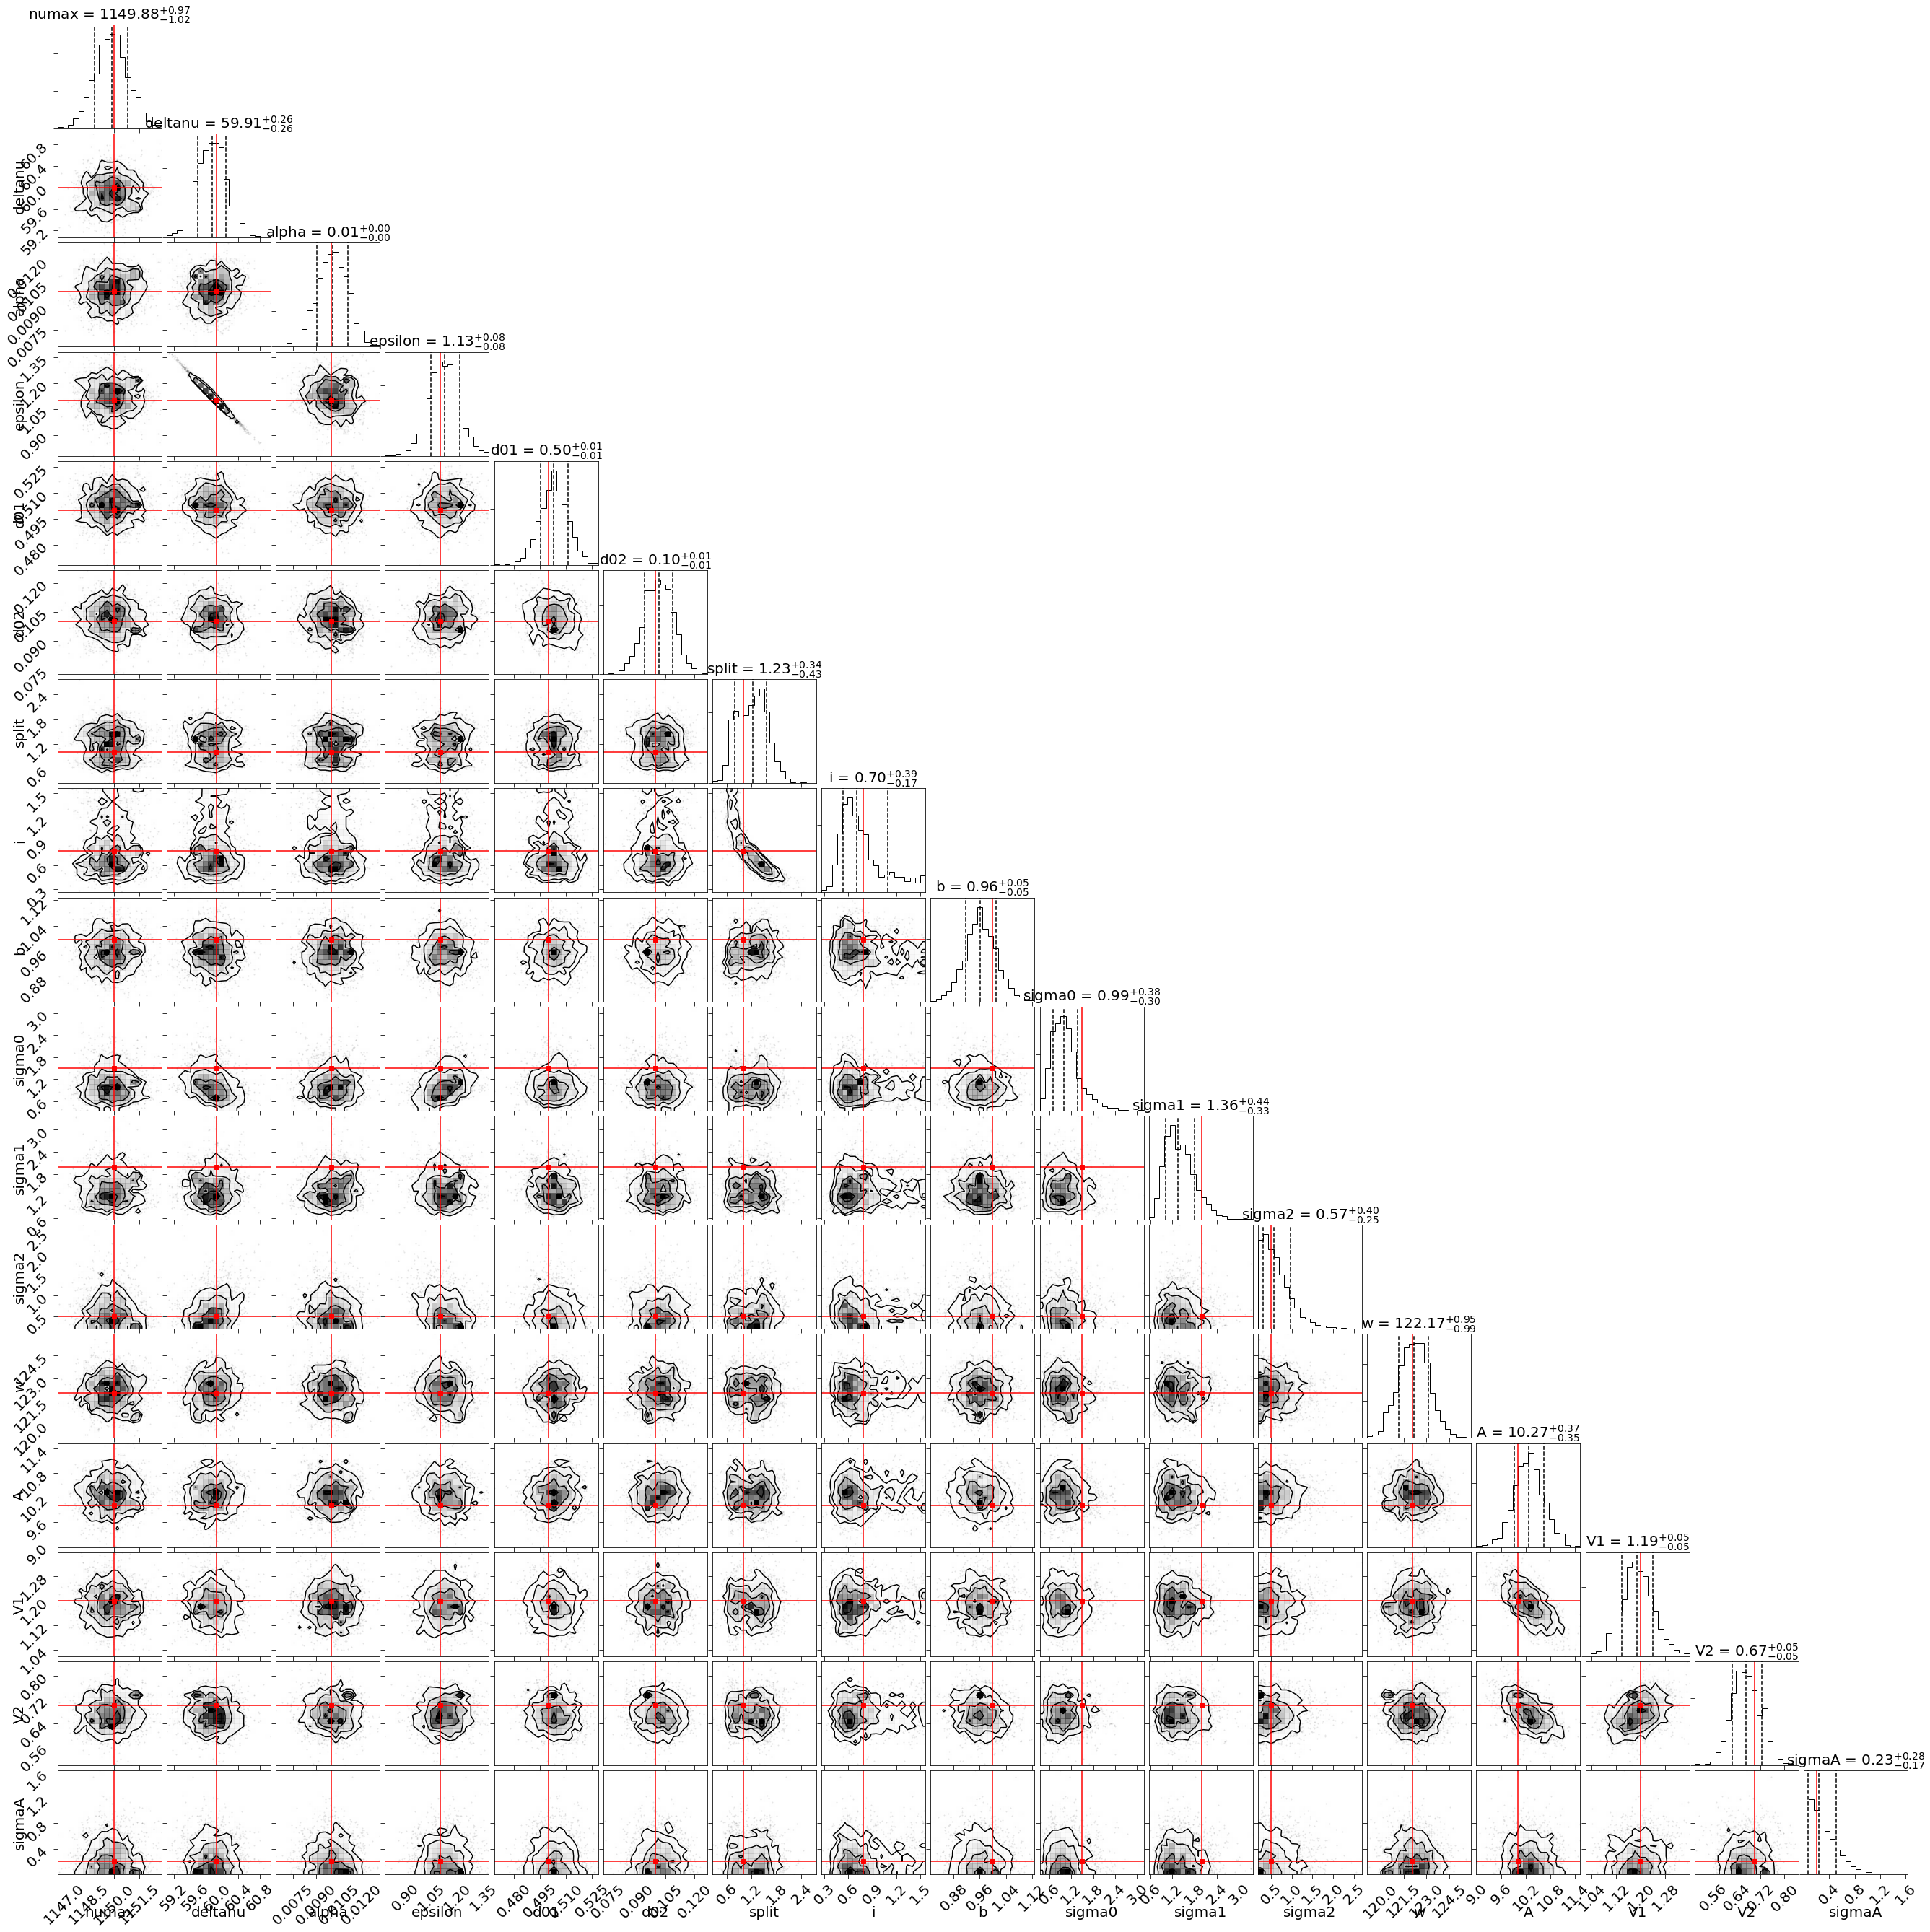

In [27]:
labels = ['numax','deltanu','alpha','epsilon','d01','d02',
          'split','i','b','sigma0','sigma1','sigma2',
          'w','A','V1','V2','sigmaA']
chain = np.array([trace[label] for label in labels])
truths = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_,
         split_, incl_, 1.,
         sigma0_, sigma1_, sigma2_, w_, A_, V1_, V2_, 0.2]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], truth_color='r',show_titles=True)
plt.show()

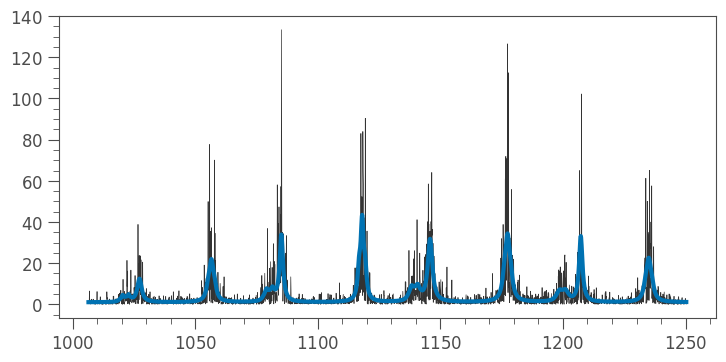

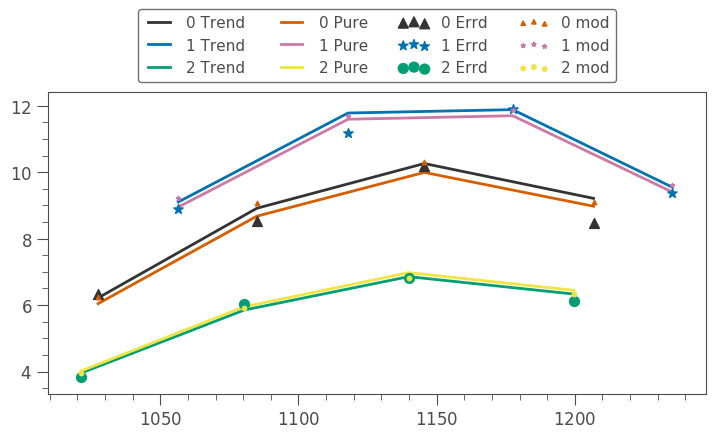

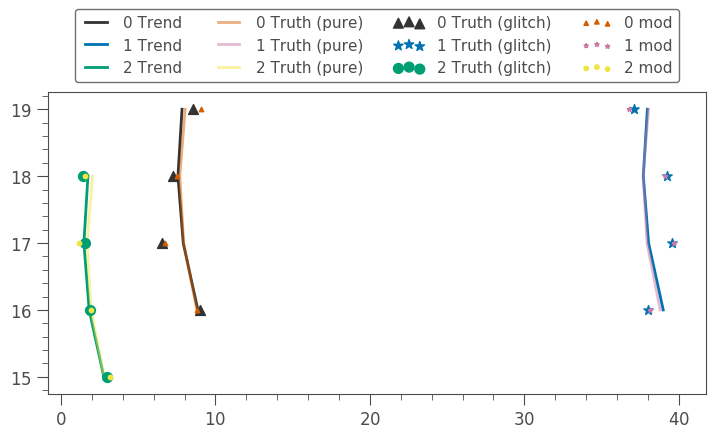

In [21]:
with plt.style.context(ms.ms):
    res_m = [np.median(trace[label], axis=0) for label in ['f0','f1','f2','g0','g1','g2',
                                                         'h0','h1','h2','split','i','b']]
    plt.plot(f, p)
    plt.plot(f, mod.model(res_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'w', 'A', 'V1','V2']]
    resls = [np.median(trace[label],axis=0) for label in ['a0','a1','a2']]
       
    ax.plot(f0_, mod.A0(f0_, res,theano=False), label='0 Trend',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, res,theano=False), label='1 Trend',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, res,theano=False), label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_, amps[0], marker='^',label='0 Errd',  s=50, zorder=2)
    ax.scatter(f1_, amps[1], marker='*',label='1 Errd',  s=50, zorder=2)
    ax.scatter(f2_, amps[2], marker='o',label='2 Errd',  s=50, zorder=2)   
  
    ax.plot(f0_, mod.A0(f0_, init_h, theano=False), label='0 Pure',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, init_h, theano=False), label='1 Pure',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, init_h, theano=False), label='2 Pure',lw=2, zorder=1)

    ax.scatter(f0_, resls[0], marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(f1_, resls[1], marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(f2_, resls[2], marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))      
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))
    plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'deltanu', 'alpha', 'epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res)%res[1], n0_, label='0 Trend',lw=2, zorder=1)
    ax.plot(mod.f1(res)%res[1], n1_, label='1 Trend',lw=2, zorder=1)
    ax.plot(mod.f2(res)%res[1], n2_, label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_%res[1], n0_, marker='^',label='0 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f1_%res[1], n1_, marker='*',label='1 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f2_%res[1], n2_, marker='o',label='2 Truth (glitch)',  s=50, zorder=2)   
    
    ax.plot(f0_true%res[1], n0_, alpha=.5, label='0 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f1_true%res[1], n1_, alpha=.5, label='1 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f2_true%res[1], n2_, alpha=.5, label='2 Truth (pure)',  lw=2, zorder=1)      
    
    ax.scatter(resls[0]%res[1], n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%res[1], n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%res[1], n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    

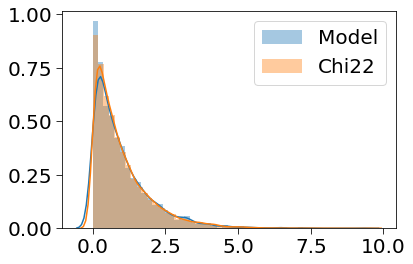

In [22]:
residual = p/mod.model(res_m, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()

## Let's investigate any divergences:

In [23]:
def pairplot_divergence(x, y, trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(x, y, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(x[divergent], y[divergent], 'o', color=divergence_color)
    return ax

def divergence_corner(trace, labels, entry=0):
    chain = np.array([trace[label] for label in labels])
    if len(chain.shape) > 2:
        chain = chain[:,:,entry]
        print('Only showing the entry [{}] for multi-parameter labels'.format(entry))
        titleadd = '[{}]'.format(entry)
    else:
        titleadd = ''
    
    K = len(chain)
    factor = 2.0           # size of one side of one panel
    lbdim = 0.5 * factor   # size of left/bottom margin
    trdim = 0.2 * factor   # size of top/right margin
    whspace = 0.05         # w/hspace size
    plotdim = factor * K + factor * (K - 1.) * whspace
    dim = lbdim + plotdim + trdim

    # Create a new figure if one wasn't provided.
    fig, axes = plt.subplots(K, K, figsize=(dim, dim))

    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim
    fig.subplots_adjust(left=lb, bottom=lb, right=tr, top=tr,
                        wspace=whspace, hspace=whspace)

    hist_kwargs = dict()
    hist_kwargs["color"] = hist_kwargs.get("color", 'k')
    for i, x in enumerate(chain):
        ax = axes[i,i]
        bins_1d = int(max(1, 20.))
        n, _, _ = ax.hist(x, bins=bins_1d, histtype='step')       


        title = "{}{}".format(labels[i], titleadd)
        ax.set_title(title)    

        for j, y in enumerate(chain):
            ax = axes[i, j]

            if j > i:    
                ax.set_frame_on(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            elif j == i:
                ax.set_xticks([])
                ax.set_yticks([])            
                continue    

            ax = pairplot_divergence(y, x, trace, ax=ax)

            if i < K - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])   
                
# plot the estimate for the mean of log(τ) cumulating mean
def biasplot(label, true):
    logtau = np.log(trace[label])
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    plt.axhline(np.log(true), lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log({})'.format(label))
    plt.title('MCMC estimation of log({})'.format(label));                

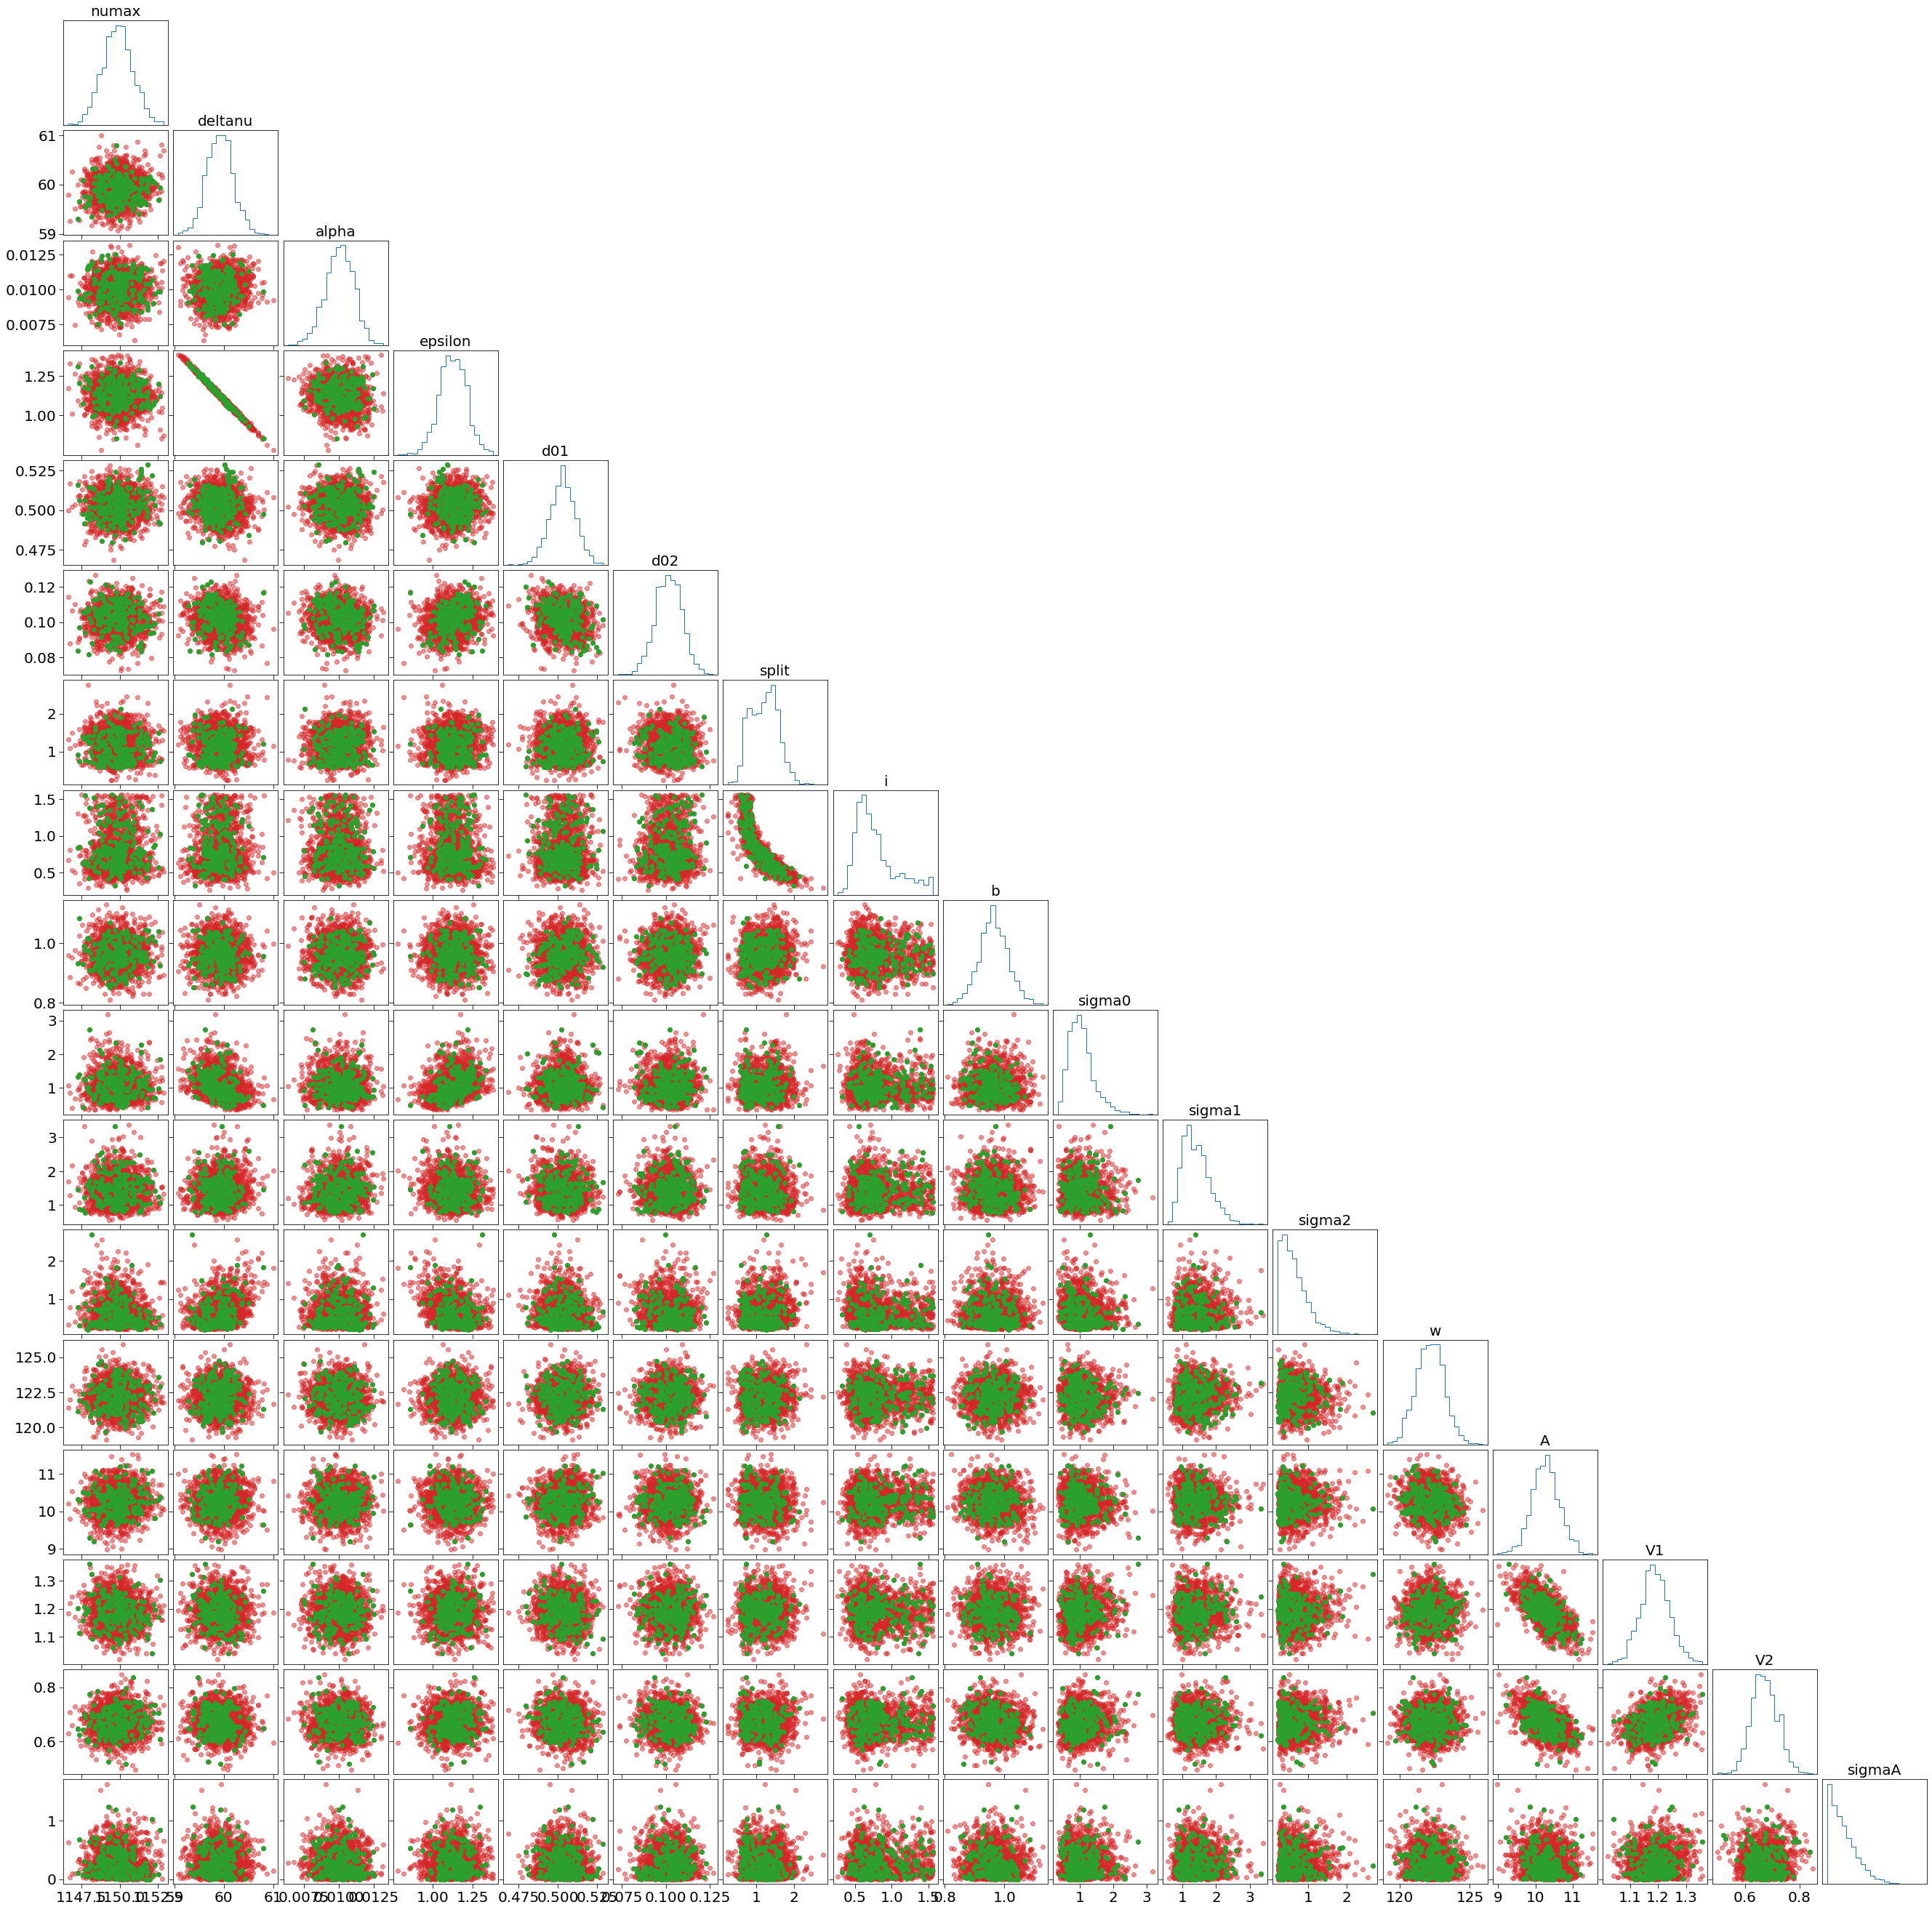

In [28]:
labels = ['numax','deltanu','alpha','epsilon','d01','d02',
          'split','i','b','sigma0','sigma1','sigma2',
          'w','A','V1','V2','sigmaA']
divergence_corner(trace, labels)

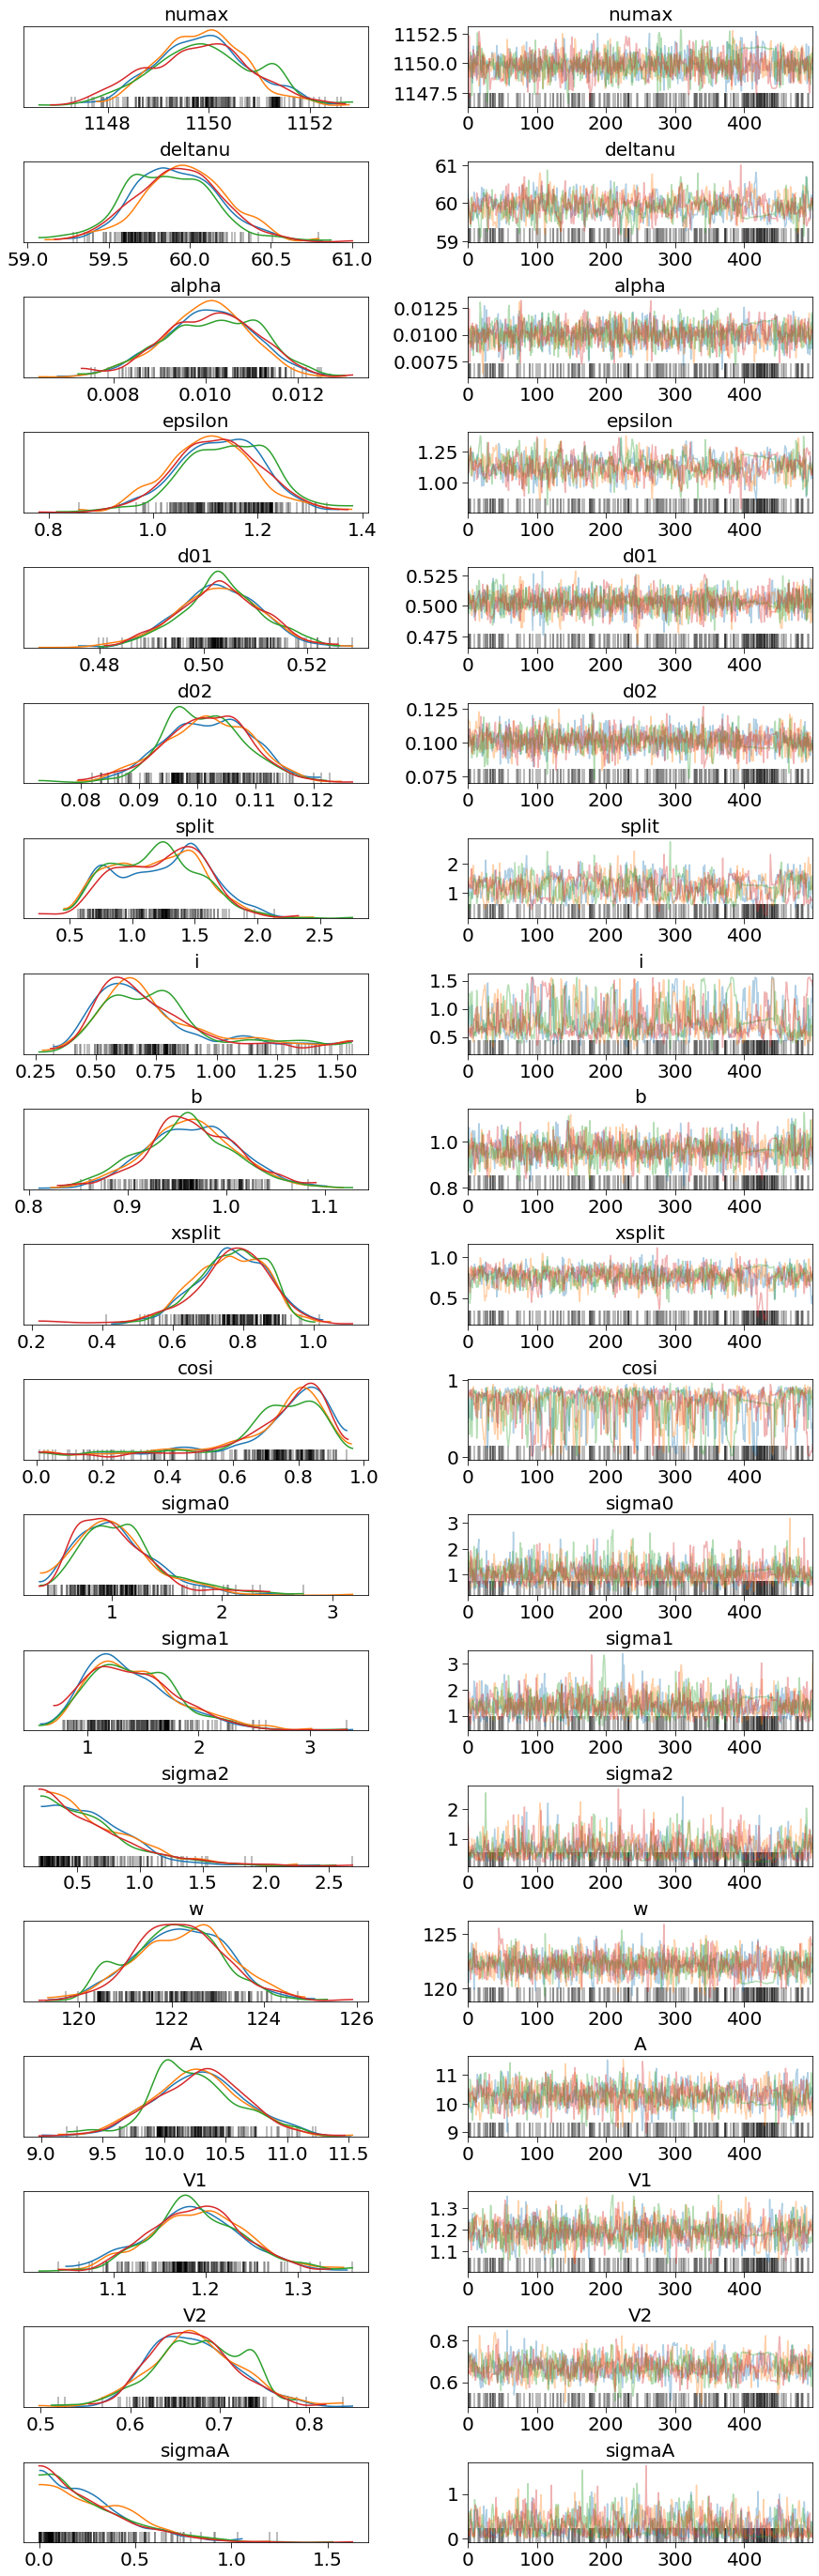

In [26]:
pm.traceplot(trace, var_names=labels)
plt.show()

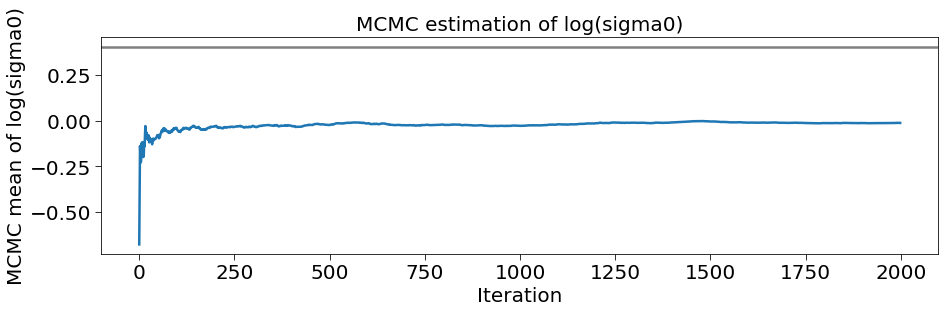

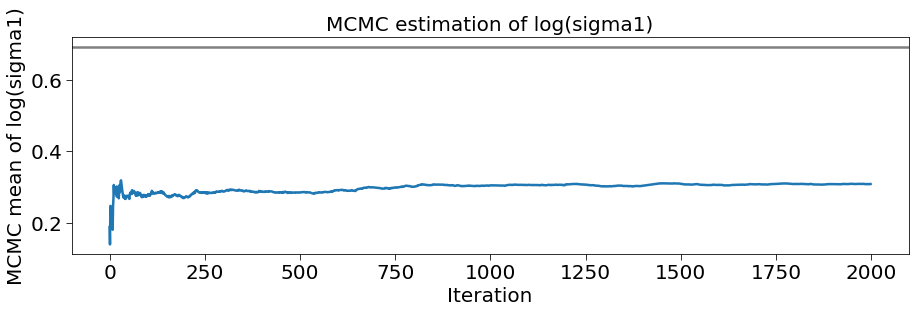

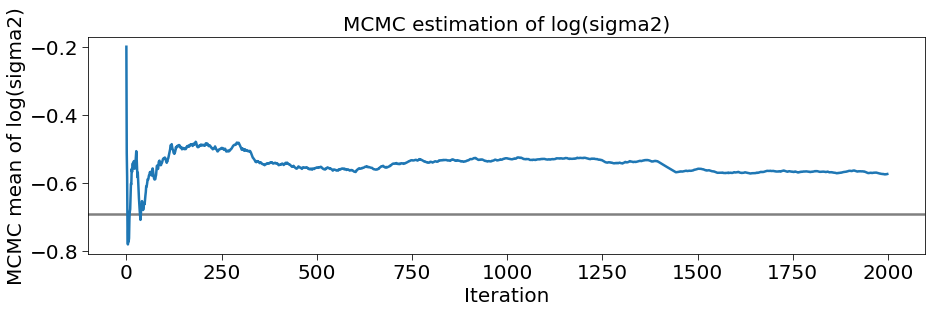

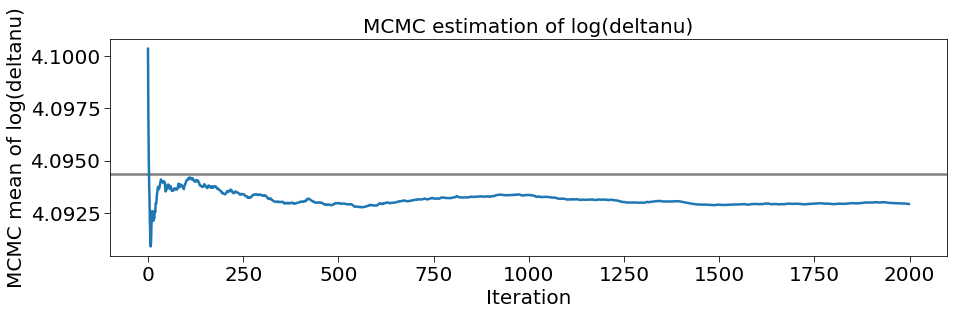

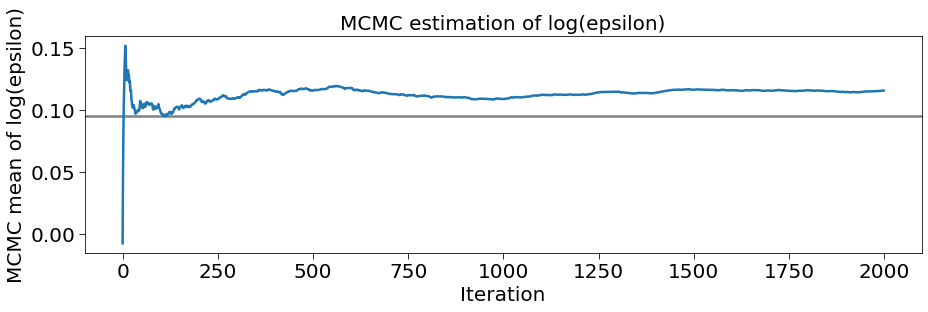

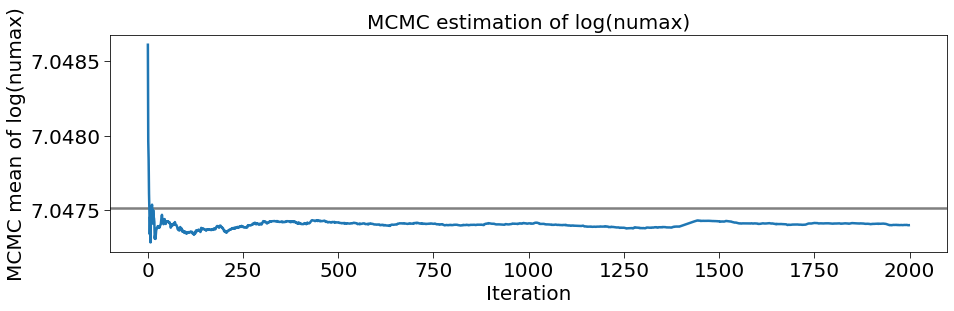

In [43]:
biasplot('sigma0',sigma0_)
biasplot('sigma1',sigma1_)
biasplot('sigma2',sigma2_)
biasplot('deltanu',deltanu_)
biasplot('epsilon', epsilon_)
biasplot('numax', numax_)

In [36]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = np.log(trace['sigma0'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(np.log(sigma0_), lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(sigma0)')
plt.title('MCMC estimation of log(sigma0)');

0.4054651081081644

In [32]:
mlogtau

[-0.6768976334321056,
 -0.3949889232999215,
 -0.137911570786145,
 -0.18305163336625346,
 -0.22827301344153153,
 -0.2194340077349616,
 -0.12213117794605226,
 -0.15360138090722472,
 -0.11693489589711237,
 -0.18054062758371328,
 -0.14536884262380306,
 -0.19847800062257612,
 -0.1823349319708735,
 -0.11959376430410629,
 -0.1399768407469477,
 -0.08455766174484496,
 -0.028770773923373905,
 -0.06528379329818201,
 -0.07427729713576432,
 -0.06348342650743014,
 -0.09094412458212688,
 -0.07708969347834677,
 -0.10259144881760651,
 -0.08830903629109876,
 -0.07833946564560822,
 -0.09469900561175161,
 -0.11807783133115059,
 -0.09040412740008329,
 -0.10083956167412787,
 -0.11083860281784697,
 -0.098567684988331,
 -0.10691552915743316,
 -0.11475744337689275,
 -0.12187505983884026,
 -0.12858595536010503,
 -0.11547400160769843,
 -0.10292240723385282,
 -0.09692097530890419,
 -0.10665198543171414,
 -0.10094386640688671,
 -0.10047396203863229,
 -0.10064283935167193,
 -0.09837967485583919,
 -0.098041167328059